# Imports

In [7]:
import os
import ast
import json
import torch
import numpy as np
import torchvision
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import albumentations as A
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import matplotlib.patches as patches
from pycocotools.cocoeval import COCOeval
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import CocoDetection as custom_dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import DetrForObjectDetection, DetrFeatureExtractor


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
google_drive_dir = '/content/drive/MyDrive/CV/'
root_dir = path = '/content/drive/MyDrive/CV/images/'
ann_file = path = '/content/drive/MyDrive/CV/Annotations.json'

# Auxiliary Functions

In [22]:
def convert_csv_to_coco(csv_path, output_json_path):
    import json
    import pandas as pd

    data = pd.read_csv(csv_path)

    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "balloon"}]
    }

    annotation_id = 1

    for idx, row in data.iterrows():
        image_id = idx + 1
        width = int(row["width"])
        height = int(row["height"])

        coco_format["images"].append({
            "id": image_id,
            "file_name": row["fname"],
            "height": height,
            "width": width
        })


        bboxes = eval(row["bbox"])
        for bbox in bboxes:
            x_min, y_min = bbox["xmin"], bbox["ymin"]
            x_max, y_max = bbox["xmax"], bbox["ymax"]
            box_width = x_max - x_min
            box_height = y_max - y_min


            if box_width > 0 and box_height > 0:
                coco_format["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 1,  # Balloon
                    "bbox": [x_min, y_min, box_width, box_height],
                    "area": box_width * box_height,
                    "iscrowd": 0
                })
                annotation_id += 1

    with open(output_json_path, "w") as json_file:
        json.dump(coco_format, json_file, indent=4)
    print(f"Файл сохранён как {output_json_path}")

csv_path = '/content/drive/MyDrive/CV/balloon-data.csv'
output_json_path = '/content/drive/MyDrive/CV/Annotations.json'
convert_csv_to_coco(csv_path, output_json_path)

coco_gt_annotations = COCO(ann_file)

Файл сохранён как /content/drive/MyDrive/CV/Annotations.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [23]:
def move_labels_to_device(labels, device):
    for label in labels:
        for key, value in label.items():
            if isinstance(value, torch.Tensor):
                label[key] = value.to(device)
    return labels


def evaluate_model_on_validation(model, val_loader, coco_gt_annotations, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in val_loader:
            orig_sizes = batch.pop('orig_sizes')
            image_ids = batch.pop('image_ids')
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            batch['labels'] = move_labels_to_device(batch['labels'], device)
            outputs = model(**batch)

            results = feature_extractor.post_process_object_detection(
                outputs=outputs,
                target_sizes=torch.tensor(orig_sizes, dtype=torch.long, device=device)
            )

            for i, result in enumerate(results):
                image_id = image_ids[i]
                boxes = result["boxes"].cpu().numpy()
                scores = result["scores"].cpu().numpy()
                labels = result["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    if score < 0.5:
                        continue
                    x_min, y_min, x_max, y_max = box
                    width = x_max - x_min
                    height = y_max - y_min
                    predictions.append({
                        "image_id": int(image_id),
                        "category_id": int(label),
                        "bbox": [x_min, y_min, width, height],
                        "score": float(score)
                    })

    coco_dt = coco_gt_annotations.loadRes(predictions)
    coco_eval = COCOeval(coco_gt_annotations, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return {
        "mAP": coco_eval.stats[0]
    }

# Dataset

In [11]:
class AugmentedDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super().__init__(root, annFile)
        self.transform = transform

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        img = np.array(img)
        orig_size = img.shape[:2]  # (height, width)
        bboxes = [obj['bbox'] for obj in target]
        category_ids = [obj['category_id'] for obj in target]
        iscrowd = [obj.get('iscrowd', 0) for obj in target]
        areas = [obj.get('area', obj['bbox'][2]*obj['bbox'][3]) for obj in target]

        image_id = target[0].get("image_id", idx) if len(target) > 0 else idx

        if self.transform:
            transformed = self.transform(
                image=img,
                bboxes=bboxes,
                category_ids=category_ids
            )
            img = transformed['image']
            bboxes = transformed['bboxes']
            category_ids = transformed['category_ids']

        annotations = []
        for bbox, category_id, crowd, area in zip(bboxes, category_ids, iscrowd, areas):
            annotations.append({
                'bbox': bbox,
                'category_id': category_id,
                'iscrowd': crowd,
                'area': area
            })

        target = {
            'image_id': image_id,
            'annotations': annotations,
            'orig_size': orig_size
        }

        return img, target

In [12]:
def collate_fn(batch):
    images, targets = zip(*batch)
    orig_sizes = [target.pop('orig_size') for target in targets]
    image_ids = [target['image_id'] for target in targets]
    encoding = feature_extractor(images=list(images), annotations=list(targets), return_tensors="pt")
    encoding["orig_sizes"] = orig_sizes
    encoding["image_ids"] = image_ids
    return encoding

### Transforms

In [13]:
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.MotionBlur(p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

val_transform = A.Compose([
    A.Resize(height=256, width=256),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

base_transform = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

# Dataset Creation

In [14]:
full_dataset = AugmentedDataset(root=root_dir, annFile=ann_file, transform=None)
dataset_size = len(full_dataset)
indices = list(range(dataset_size))

train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Without Augmentation|

In [15]:
train_dataset_no_aug = AugmentedDataset(root=root_dir, annFile=ann_file, transform=base_transform)
val_dataset_no_aug = AugmentedDataset(root=root_dir, annFile=ann_file, transform=base_transform)
test_dataset_no_aug = AugmentedDataset(root=root_dir, annFile=ann_file, transform=base_transform)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## With Augmentation

In [16]:
train_dataset_aug = Subset(AugmentedDataset(root=root_dir, annFile=ann_file, transform=train_transform), train_indices)
val_dataset_aug = Subset(AugmentedDataset(root=root_dir, annFile=ann_file, transform=val_transform), val_indices)
test_dataset_aug = Subset(AugmentedDataset(root=root_dir, annFile=ann_file, transform=val_transform), test_indices)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Train

## Function to train and plot

In [17]:
def train_save_model(model, num_epochs, train_loader_aug, val_loader_aug,test_loader_aug, optimizer,scheduler,model_save_name=""):
    metrics = {
        "epochs": [],
        "train_loss": [],
        "val_loss": [],
        "epoch_metrics": [],
        "mAP": []
    }
    num_epochs = 20
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader_aug):
            orig_sizes = batch.pop('orig_sizes', None)
            image_ids = batch.pop('image_ids', None)
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            batch['labels'] = move_labels_to_device(batch['labels'], device)
            outputs = model(**batch)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        train_loss /= len(train_loader_aug)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}")

        model.eval()
        val_loss = 0
        epoch_loss_ce = 0
        epoch_loss_bbox = 0
        epoch_loss_giou = 0

        with torch.no_grad():
            for batch in val_loader_aug:
                orig_sizes = batch.pop('orig_sizes')
                image_ids = batch.pop('image_ids')
                batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

                batch['labels'] = move_labels_to_device(batch['labels'], device)
                outputs = model(**batch)
                loss = outputs.loss
                val_loss += loss.item()
                epoch_loss_ce += outputs.loss_dict.get("loss_ce", 0).item()
                epoch_loss_bbox += outputs.loss_dict.get("loss_bbox", 0).item()
                epoch_loss_giou += outputs.loss_dict.get("loss_giou", 0).item()

        val_loss /= len(val_loader_aug)
        epoch_loss_ce /= len(val_loader_aug)
        epoch_loss_bbox /= len(val_loader_aug)
        epoch_loss_giou /= len(val_loader_aug)

        print(f"Validation Loss: {val_loss}")
        best_model_path = os.path.join(google_drive_dir, f"best_model_{model_save_name}.pth")
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), best_model_path)
          print(f"Model saved at epoch {epoch + 1} with validation loss {val_loss}")
        coco_eval_results = evaluate_model_on_validation(model, val_loader_aug, coco_gt_annotations, device)

        metrics["epochs"].append(epoch + 1)
        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["epoch_metrics"].append({
            "loss_ce": epoch_loss_ce,
            "loss_bbox": epoch_loss_bbox,
            "loss_giou": epoch_loss_giou
        })
        metrics["mAP"].append(coco_eval_results["mAP"])

        scheduler.step(val_loss)

    torch.cuda.empty_cache()
    metrics_path = os.path.join(google_drive_dir, f"metrics_{model_save_name}.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f)
    print(f"Metrics saved to {metrics_path}")

    print("Evaluating on validation set:")
    evaluate_model_on_validation(model, val_loader_aug, coco_gt_annotations, device)

    print("Evaluating on test set:")
    evaluate_model_on_validation(model, test_loader_aug, coco_gt_annotations, device)

    return metrics

In [18]:
def plot_loss_components(metrics):
    loss_ce = [m["loss_ce"] for m in metrics["epoch_metrics"]]
    loss_bbox = [m["loss_bbox"] for m in metrics["epoch_metrics"]]
    loss_giou = [m["loss_giou"] for m in metrics["epoch_metrics"]]

    epochs = metrics["epochs"]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss_ce, label="Loss CE", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss CE")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss_bbox, label="Loss BBox", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss BBox")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, loss_giou, label="Loss GIoU", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss GIoU")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def visualize_prediction(image_path, predictions, score_threshold=0.5):
    img = np.array(Image.open(image_path))
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    for pred in predictions:
        score = pred['score']
        if score < score_threshold:
            continue

        x, y, w, h = pred['bbox']
        label = pred['category_id']
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x, y - 5,
            f"ID: {label}, Score: {score:.2f}",
            color='white',
            fontsize=10,
            bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.axis('off')
    plt.show()
def test_and_visualize(model, test_loader, coco_gt_annotations, device, image_idx=0):
    model.eval()
    predictions = []
    image_data = test_loader.dataset[image_idx]
    image, target = image_data
    orig_size = target['orig_size']
    image_id = target['image_id']
    image_path = os.path.join(root_dir, coco_gt_annotations.loadImgs(image_id)[0]['file_name'])

    with torch.no_grad():
        batch = feature_extractor(images=[image], return_tensors="pt")
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        results = feature_extractor.post_process_object_detection(
            outputs=outputs,
            target_sizes=torch.tensor([orig_size], dtype=torch.long, device=device)
        )
        result = results[0]
        boxes = result["boxes"].cpu().numpy()
        scores = result["scores"].cpu().numpy()
        labels = result["labels"].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            if score < 0.8:  # threshold
                continue
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            predictions.append({
                "image_id": int(image_id),
                "category_id": int(label),
                "bbox": [x_min, y_min, width, height],
                "score": float(score)
            })

    visualize_prediction(image_path, predictions)

    coco_dt = coco_gt_annotations.loadRes(predictions)
    coco_eval = COCOeval(coco_gt_annotations, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return {
        "mAP": coco_eval.stats[0]
    }

## TRAINING PROCESS

### With Aug

In [10]:
# model init
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
model.to(device)

# optimizer+scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

# loaders
batch_size = 16
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader_aug = DataLoader(val_dataset_aug,batch_size=batch_size,shuffle=False,collate_fn=collate_fn)
test_loader_aug = DataLoader(test_dataset_aug,batch_size=batch_size,shuffle=False,collate_fn=collate_fn)

# epochs
num_epochs=20

metrics = train_save_model(model, num_epochs, train_loader_aug, val_loader_aug,test_loader_aug,optimizer,scheduler)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Epoch 1/20, Train Loss: 2.4095056653022766
Validation Loss: 1.363525390625
Model saved at epoch 1 with validation loss 1.363525390625
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.061
 Average Recal

100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 2/20, Train Loss: 1.3209248483181
Validation Loss: 1.1224761009216309
Model saved at epoch 2 with validation loss 1.1224761009216309
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.073
 Average 

100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Epoch 3/20, Train Loss: 1.330937534570694
Validation Loss: 0.9853610992431641
Model saved at epoch 3 with validation loss 0.9853610992431641
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.074
 Averag

100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


Epoch 4/20, Train Loss: 1.189441293478012
Validation Loss: 1.0902493000030518
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 

100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 5/20, Train Loss: 1.0099537670612335
Validation Loss: 0.9390335083007812
Model saved at epoch 5 with validation loss 0.9390335083007812
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.079
 Avera

100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Epoch 6/20, Train Loss: 0.9596333205699921
Validation Loss: 0.9332278966903687
Model saved at epoch 6 with validation loss 0.9332278966903687
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.079
 Avera

100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Epoch 7/20, Train Loss: 1.2801614999771118
Validation Loss: 1.0010446310043335
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 8/20, Train Loss: 1.21066452562809
Validation Loss: 1.1720504760742188
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]

100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Epoch 9/20, Train Loss: 1.1514665186405182
Validation Loss: 1.231266975402832
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 

100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 10/20, Train Loss: 1.4001328349113464
Validation Loss: 1.178065299987793
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Epoch 11/20, Train Loss: 0.9413400292396545
Validation Loss: 1.0464117527008057
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 12/20, Train Loss: 0.8585324436426163
Validation Loss: 0.9931545257568359
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 13/20, Train Loss: 0.7055121511220932
Validation Loss: 1.0618774890899658
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Epoch 14/20, Train Loss: 0.9009177386760712
Validation Loss: 1.1071724891662598
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Epoch 15/20, Train Loss: 0.8655838072299957
Validation Loss: 0.8835313320159912
Model saved at epoch 15 with validation loss 0.8835313320159912
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.084
 Ave

100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Epoch 16/20, Train Loss: 0.7643984407186508
Validation Loss: 0.8235177993774414
Model saved at epoch 16 with validation loss 0.8235177993774414
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.078
 Ave

100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 17/20, Train Loss: 0.9132613688707352
Validation Loss: 0.8730159997940063
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 18/20, Train Loss: 0.987227126955986
Validation Loss: 0.8558334112167358
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Epoch 19/20, Train Loss: 0.8132931888103485
Validation Loss: 0.8542678356170654
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Epoch 20/20, Train Loss: 0.9269062727689743
Validation Loss: 0.8742730617523193
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

{'epochs': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'train_loss': [2.4095056653022766,
  1.3209248483181,
  1.330937534570694,
  1.189441293478012,
  1.0099537670612335,
  0.9596333205699921,
  1.2801614999771118,
  1.21066452562809,
  1.1514665186405182,
  1.4001328349113464,
  0.9413400292396545,
  0.8585324436426163,
  0.7055121511220932,
  0.9009177386760712,
  0.8655838072299957,
  0.7643984407186508,
  0.9132613688707352,
  0.987227126955986,
  0.8132931888103485,
  0.9269062727689743],
 'val_loss': [1.363525390625,
  1.1224761009216309,
  0.9853610992431641,
  1.0902493000030518,
  0.9390335083007812,
  0.9332278966903687,
  1.0010446310043335,
  1.1720504760742188,
  1.231266975402832,
  1.178065299987793,
  1.0464117527008057,
  0.9931545257568359,
  1.0618774890899658,
  1.1071724891662598,
  0.8835313320159912,
  0.8235177993774414,
  0.8730159997940063,
  0.8558334112167358,
  0.8542678356170654,
  0.874

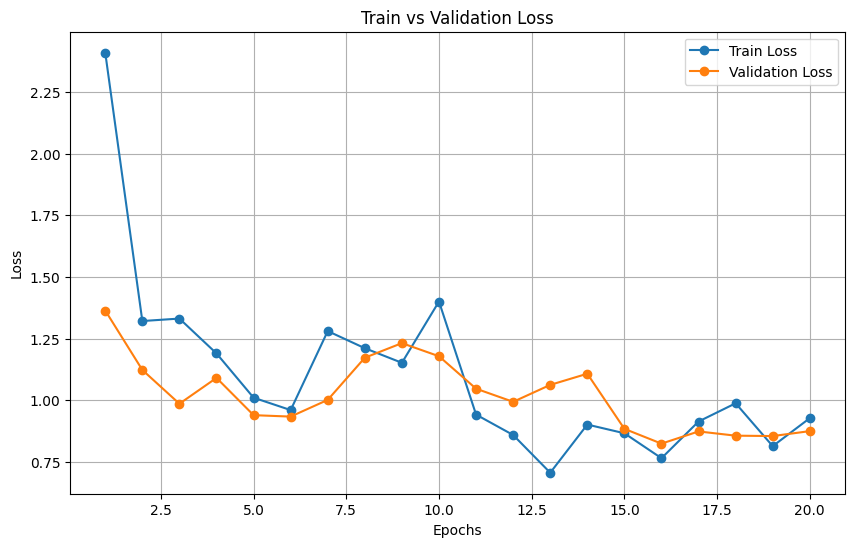

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["epochs"], metrics["train_loss"], label="Train Loss", marker="o")
plt.plot(metrics["epochs"], metrics["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


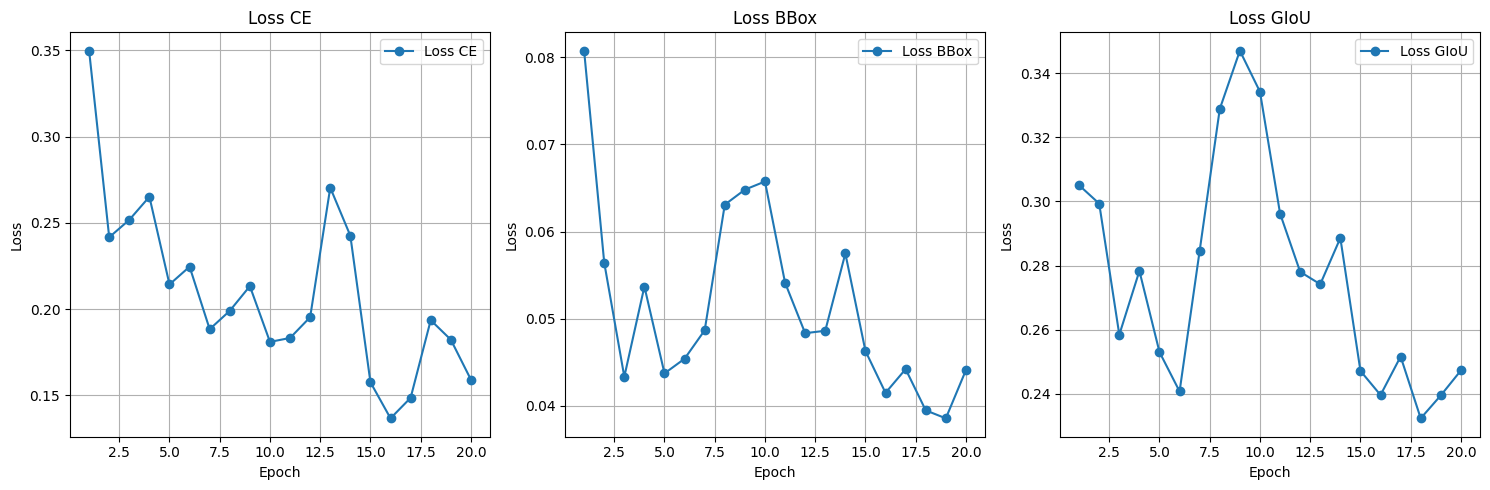

In [14]:
metrics_path = os.path.join(google_drive_dir, "metrics.json")
with open(metrics_path, "r") as f:
    metrics = json.load(f)

plot_loss_components(metrics)


Testing the model on test dataset and visualizing predictions...


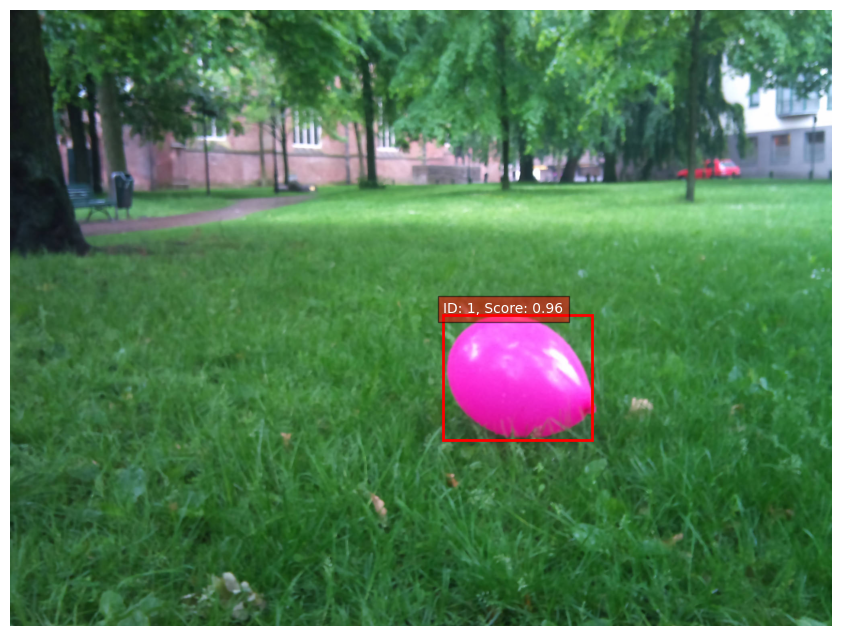

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [19]:
print("Testing the model on test dataset and visualizing predictions...")
results = test_and_visualize(model, test_loader_aug, coco_gt_annotations, device, image_idx=0)
print(f"Test Results: mAP = {results['mAP']:.4f}")

### Without Aug

In [19]:
# model init
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
model.to(device)

# optimizer+scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

# loaders
batch_size = 16
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader_no_aug = DataLoader(val_dataset_no_aug,batch_size=batch_size,shuffle=False,collate_fn=collate_fn)
test_loader_no_aug = DataLoader(test_dataset_no_aug,batch_size=batch_size,shuffle=False,collate_fn=collate_fn)

# epochs
num_epochs=20

metrics = train_save_model(model, num_epochs, train_loader_no_aug, val_loader_no_aug,test_loader_no_aug,optimizer,scheduler,
                           model_save_name='no_aug')

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObject

Epoch 1/20, Train Loss: 2.2030912399291993
Validation Loss: 1.0719757080078125
Model saved at epoch 1 with validation loss 1.0719757080078125
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.517
 Avera

100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


Epoch 2/20, Train Loss: 1.148521089553833
Validation Loss: 1.0103591561317444
Model saved at epoch 2 with validation loss 1.0103591561317444
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.518
 Averag

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 3/20, Train Loss: 1.1313634753227233
Validation Loss: 1.0499682188034059
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 4/20, Train Loss: 1.0343320846557618
Validation Loss: 0.8759979844093323
Model saved at epoch 4 with validation loss 0.8759979844093323
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.559
 Avera

100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 5/20, Train Loss: 0.9619779109954834
Validation Loss: 0.7953238844871521
Model saved at epoch 5 with validation loss 0.7953238844871521
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.592
 Avera

100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Epoch 6/20, Train Loss: 0.9137376546859741
Validation Loss: 0.7207276821136475
Model saved at epoch 6 with validation loss 0.7207276821136475
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Avera

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 7/20, Train Loss: 0.8500849723815918
Validation Loss: 0.7633147478103638
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 8/20, Train Loss: 0.7812426090240479
Validation Loss: 0.7256439328193665
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 9/20, Train Loss: 0.8201194167137146
Validation Loss: 0.7360778093338013
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Epoch 10/20, Train Loss: 0.7552051186561585
Validation Loss: 0.644093644618988
Model saved at epoch 10 with validation loss 0.644093644618988
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.793
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.624
 Avera

100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 11/20, Train Loss: 0.7145382523536682
Validation Loss: 0.6015173435211182
Model saved at epoch 11 with validation loss 0.6015173435211182
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.643
 Ave

100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


Epoch 12/20, Train Loss: 0.7932414054870606
Validation Loss: 0.7658685564994812
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 13/20, Train Loss: 0.8727409839630127
Validation Loss: 0.7443055510520935
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 14/20, Train Loss: 0.7388692677021027
Validation Loss: 0.6767812728881836
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.842
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 15/20, Train Loss: 0.7067376792430877
Validation Loss: 0.665770161151886
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.622
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.828
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Epoch 16/20, Train Loss: 0.7983802318572998
Validation Loss: 0.8943926811218261
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 17/20, Train Loss: 0.9965499758720398
Validation Loss: 0.8556923031806946
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 18/20, Train Loss: 1.049826180934906
Validation Loss: 0.8378843426704407
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 19/20, Train Loss: 0.9058887720108032
Validation Loss: 0.783928108215332
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.756
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.603
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 20/20, Train Loss: 0.8314906358718872
Validation Loss: 0.6894382953643798
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=10

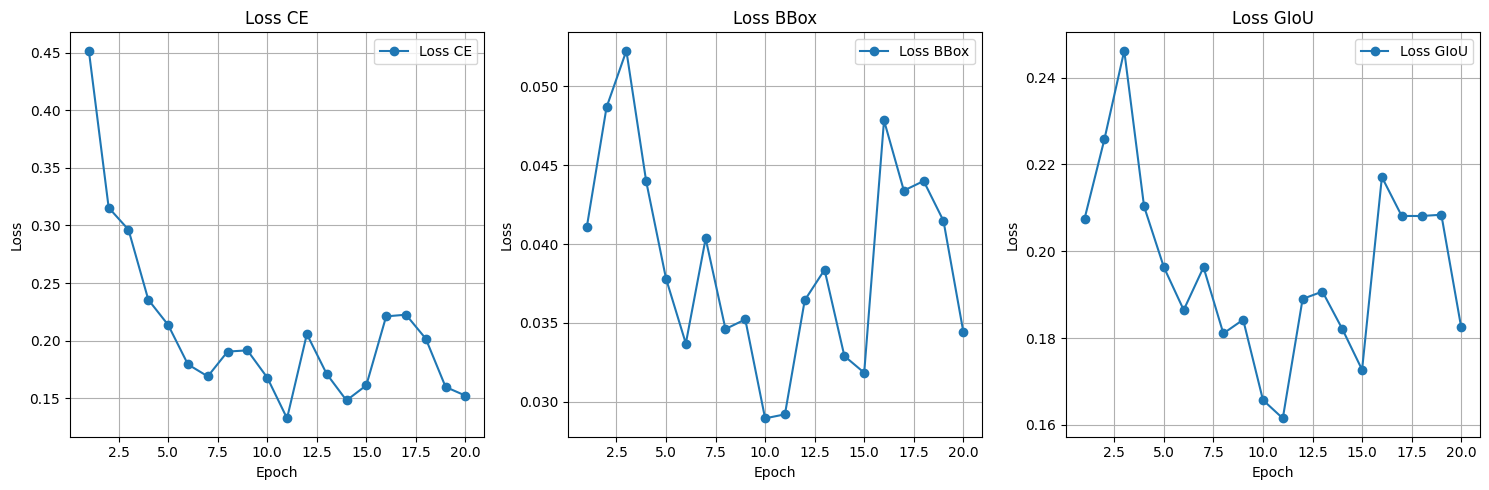

In [20]:
metrics_path = os.path.join(google_drive_dir, "metrics_no_aug.json")
with open(metrics_path, "r") as f:
    metrics_no_aug = json.load(f)

plot_loss_components(metrics_no_aug)


Testing the model on test dataset and visualizing predictions...


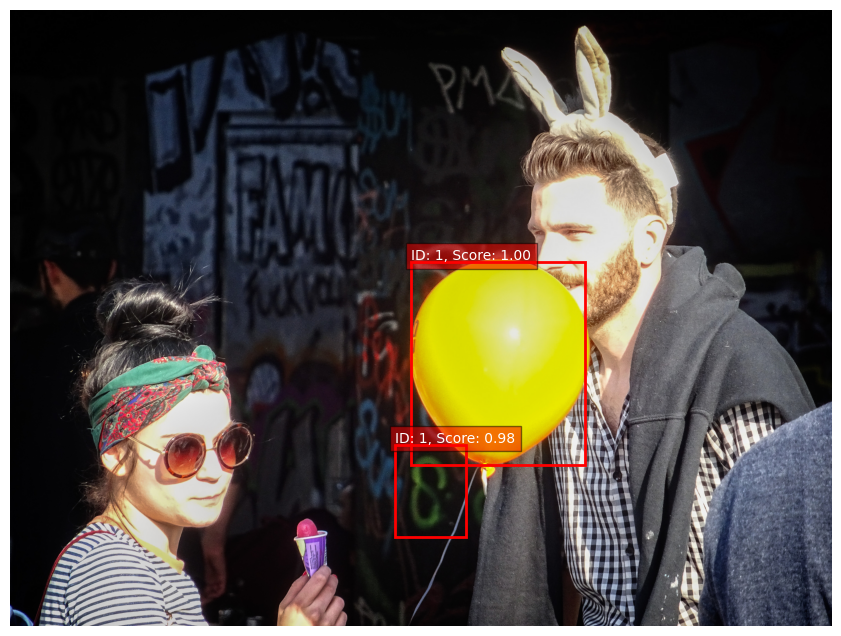

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [21]:
print("Testing the model on test dataset and visualizing predictions...")
results = test_and_visualize(model, test_loader_no_aug, coco_gt_annotations, device, image_idx=0)
print(f"Test Results: mAP = {results['mAP']:.4f}")

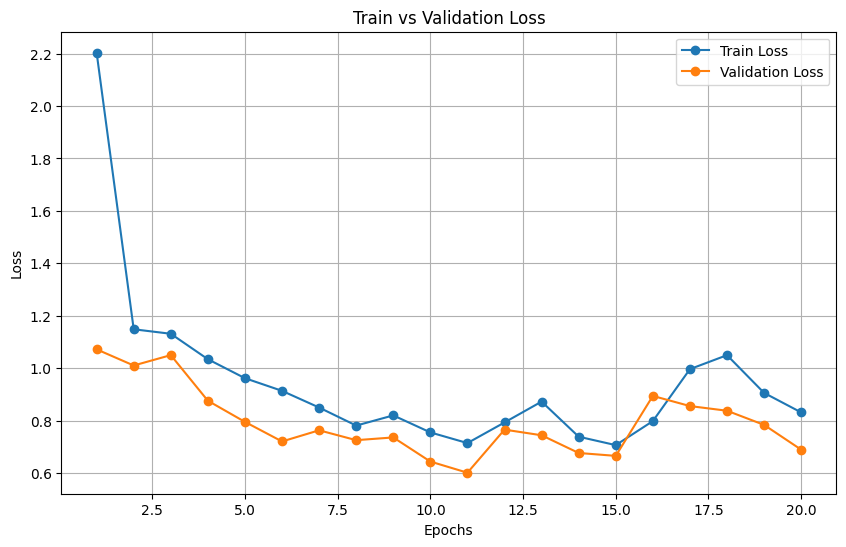

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["epochs"], metrics["train_loss"], label="Train Loss", marker="o")
plt.plot(metrics["epochs"], metrics["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
